In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import copy
from functools import partial

In [17]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
os.environ['METALHOME'] = '/dfs/scratch1/saelig/slicing/'

In [18]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel, SliceRepModel, SliceQPModel, SliceCatModel, SliceEnsembleModel
from metal.mmtl.slicing.moe_model import MoEModel

from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, train_slice_experts
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

ModuleNotFoundError: No module named 'metal'

In [7]:
from metal.utils import set_seed

seed = 444
set_seed(seed)

ModuleNotFoundError: No module named 'metal'

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [6]:
from functools import partial
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.15)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=5000, label_flips=label_flips)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [7]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

remainder = lambda X: np.logical_not(np.logical_or(slice_1(X), slice_2(X)))

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=1000, 
   slice_funcs={"slice_1": slice_1, "slice_2": slice_2, "remainder": remainder}
#    slice_funcs={"slice_1": flip_1, "slice_2": flip_2}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


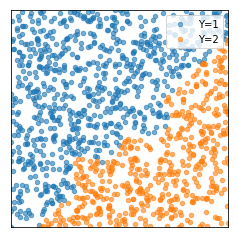

Vizualizing labelset:slice_1:pred from payload_test


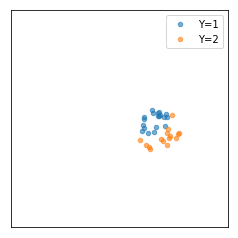

Vizualizing labelset:slice_1:ind from payload_test


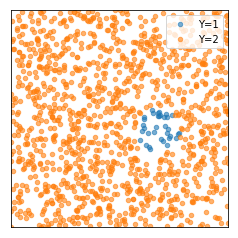

Vizualizing labelset:slice_2:pred from payload_test


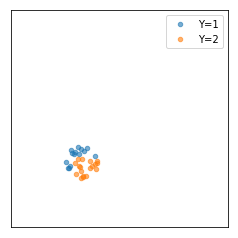

Vizualizing labelset:slice_2:ind from payload_test


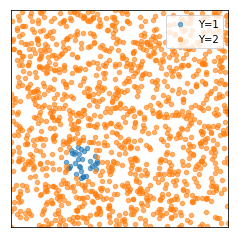

Vizualizing labelset:remainder:pred from payload_test


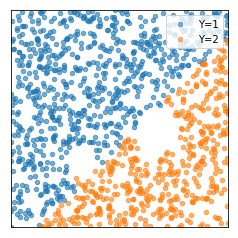

Vizualizing labelset:remainder:ind from payload_test


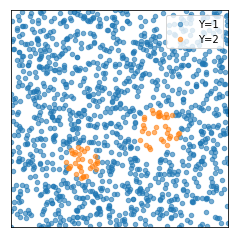

In [9]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [10]:
# all models to test to test
all_slice_funcs = {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn}
slice_loss_multiplier = 1.0 / (2*len(all_slice_funcs))
# h_dim = 2
rep_dim = 7
h_dim = None
# h_dim = 2

model_configs = {
#     'soft_ens_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'model_class': SliceEnsembleModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'custom_neck_dim': 2*len(all_slice_funcs)
#     }, 
#     'soft_cat_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'create_preds': False,
#         'model_class': SliceCatModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'h_dim': h_dim,
#         'custom_neck_dim': (h_dim+1)*len(all_slice_funcs)
#     },   
#     'soft_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'model_class': SliceModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         }
#     },   
#     'soft_param_rep': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'create_preds': False,
#         'model_class': SliceRepModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'h_dim': h_dim
#     },
    'slice_qp_rep': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'create_preds': False,
        'create_shared_slice_pred': True,
        'model_class': SliceQPModel,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        },
        'h_dim': h_dim,
        'use_ind_module': True
    },
#     }
#     'hard_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': False,
#         'model_class': MetalModel,
#         'slice_weights': {'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier}
#     },
#     'manual_reweighting': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': False,
#         'slice_weights': {"slice_1": 50}, # 10x weight of slice_2, everythign else default
#         'model_class': MetalModel        
#     },
#     'moe': {
#         'slice_funcs': {},
#         'create_ind': False,
#         'model_class': MoEModel
#     },
#     'naive': {
#         'slice_funcs': {},
#         'model_class': MetalModel   
#     }
}

In [11]:
train_kwargs = {
    "lr": 0.01, 
    "n_epochs": 10,
    "checkpoint_best": False,
    "log_every": 5.0,
    "writer": "tensorboard", 
    "verbose": True,
    "progress_bar": False
}

==========Initializing + Training slice_qp_rep==========
Creating 7 tasks...
BinaryClassificationTask(name=test_task:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_1:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:slice_2:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_2:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:pred': 'test_task:slice_1:pred', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:pred': 'test_task:slice_2:pred', 'labelset:slice_2

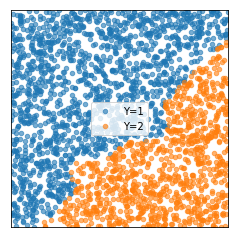

Vizualizing labelset:slice_1:pred from payload_train


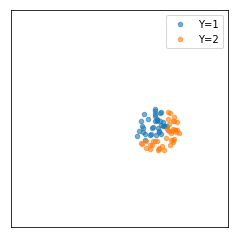

Vizualizing labelset:slice_1:ind from payload_train


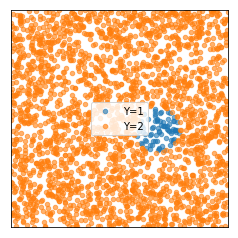

Vizualizing labelset:slice_2:pred from payload_train


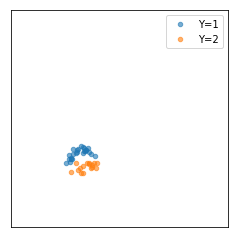

Vizualizing labelset:slice_2:ind from payload_train


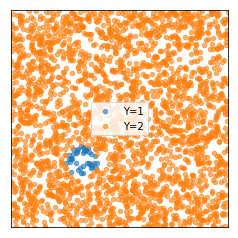

Vizualizing labelset:BASE:pred from payload_train


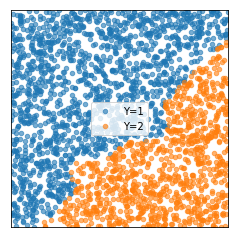

Vizualizing labelset:BASE:ind from payload_train


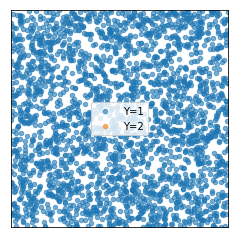

No cuda device available. Using cpu instead.

Network architecture:
SliceQPModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred)

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'model/valid/all/loss': 0.04557008313712012,
 'test_task/payload_test/labelset_gold/acc_f1': 0.9694745098039216,
 'test_task/payload_test/labelset_gold/accuracy': 0.9664,
 'test_task/payload_test/labelset_gold/f1': 0.9725490196078431,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9727250409165302,
 'test_task/payload_train/labelset_gold/accuracy': 0.97,
 'test_task/payload_train/labelset_gold/f1': 0.9754500818330606,
 'test_task/payload_valid/labelset_gold/acc_f1': 0.9741033310673011,
 'test_task/payload_valid/labelset_gold/accuracy': 0.972,
 'test_task/payload_valid/labelset_gold/f1': 0.9762066621346023,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/acc_f1': 1.0,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/f1': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/acc_f1': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:

In [12]:
%%time
trained_models = {}
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    slice_weights = config.get("slice_weights", {})
    create_ind = config.get("create_ind", True)
    create_preds = config.get("create_preds", True)
    custom_neck_dim = config.get("custom_neck_dim", None)
    h_dim = config.get("h_dim", None)
    create_shared_slice_pred = config.get("create_shared_slice_pred", None)
    use_ind_module = config.get("use_ind_module", None)
          
    tasks = create_tasks(
        task_name, 
        rep_dim=rep_dim,
        slice_names=list(slice_funcs.keys()), 
        slice_weights=slice_weights, 
        create_ind=create_ind,
        create_preds=create_preds,
        custom_neck_dim=custom_neck_dim,
        create_shared_slice_pred=create_shared_slice_pred,
        use_ind_module=use_ind_module,
        h_dim=h_dim,
        verbose=True
    )
    payloads = create_payloads(
        task_name, 
        uid_lists, 
        Xs, 
        Ys,
        batch_size=16, 
#         batch_size=128,
        slice_funcs=slice_funcs, 
        create_ind=create_ind,
        create_preds=create_preds,
        create_shared_slice_pred=create_shared_slice_pred,
        verbose=True
    )
    visualize_payload(payloads[0])
          
    if model_name == 'moe':
        # train for same total num epochs
        expert_train_kwargs = copy.deepcopy(train_kwargs)
        expert_train_kwargs['n_epochs'] = int(train_kwargs['n_epochs'] / (len(all_slice_funcs) + 1))
        experts = train_slice_experts(
            uid_lists, Xs, Ys, MetalModel, all_slice_funcs, **expert_train_kwargs
        )
        model = model_class(tasks, experts, verbose=False, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **expert_train_kwargs)
    else:
        model = model_class(tasks, h_dim=h_dim, verbose=True, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **train_kwargs)
    print(metrics_dict) 
    trained_models[model_name] = model

### Confirm that slice heads are actually experts at their jobs...

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:ind' -> task 'None' (originally, test_task:slice_1:ind).
labelset 'labelset:slice_2:ind' -> task 'None' (originally, test_task:slice_2:ind).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task:remainder:pred).
labelset 'labelset:remainder:ind' -> task 'None' (originally, test_task:remainder:ind).
==========Evaluating slice_qp_rep==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.8507130124777182,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.8529411764705882,
    'test_task:slice_1:pred/payload_test/labelset:s

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


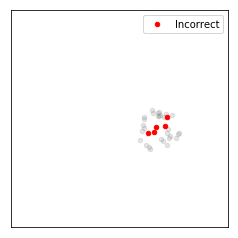

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


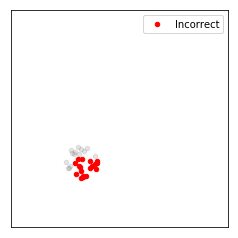

In [13]:
for model_name in model_configs.keys():
    if model_name == 'soft_param':
        labelcats_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",    
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind",
        }
    else:
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",        
        }

    eval_payload.remap_labelsets(labels_to_tasks, default_none=True)
    if model_name in ["hard_param", "soft_param", "manual_reweighting", "slice_qp_rep"]:
        print(f"{'='*10}Evaluating {model_name}{'='*10}")
        score_and_visualize(trained_models[model_name], eval_payload)

### Evaluate model on primary task head

labelset 'labelset_gold' -> task 'test_task' (originally, None).
labelset 'labelset:slice_1:pred' -> task 'test_task' (originally, test_task:slice_1:pred).
labelset 'labelset:slice_2:pred' -> task 'test_task' (originally, test_task:slice_2:pred).
labelset 'labelset:remainder:pred' -> task 'test_task' (originally, None).
==========Evaluating slice_qp_rep==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9916004635181256,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9907094594594594,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9924914675767917,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.40106951871657753,
    'test_task/pa

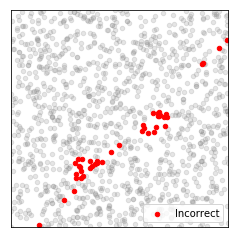

Vizualizing test_task predictions on labelset:slice_1:pred


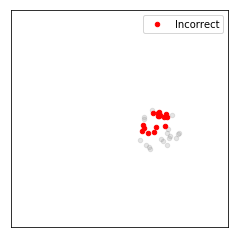

Vizualizing test_task predictions on labelset:slice_2:pred


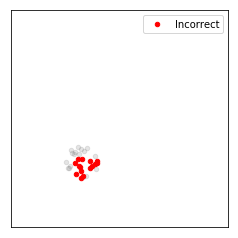

Vizualizing test_task predictions on labelset:remainder:pred


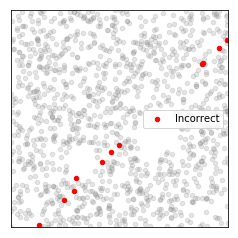

In [14]:
# map all labelsets to the primary task_head 
eval_payload.remap_labelsets(labels_to_tasks= {
        "labelset_gold": "test_task",
        "labelset:slice_1:pred": "test_task",
        "labelset:slice_2:pred": "test_task",
        "labelset:remainder:pred": "test_task",
    }, default_none=True
                            
)

for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    score_and_visualize(trained_models[model_name], eval_payload)

### Visualize Attention Weights of `soft_param`

********** slice_qp_rep **********
labelset 'labelset:slice_1:ind' -> task 'test_task:slice_1:ind' (originally, None).
labelset 'labelset:slice_2:ind' -> task 'test_task:slice_2:ind' (originally, None).
Vizualizing test_task:BASE:ind attention on labelset_gold


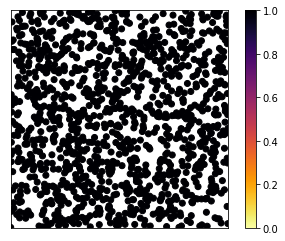

Vizualizing test_task:slice_1:ind attention on labelset_gold


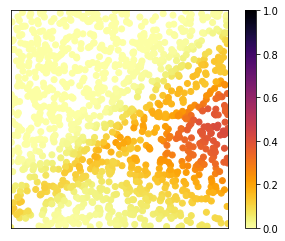

Vizualizing test_task:slice_2:ind attention on labelset_gold


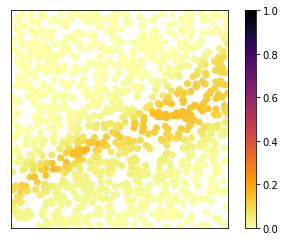

Vizualizing test_task:BASE:ind attention on labelset:slice_1:pred


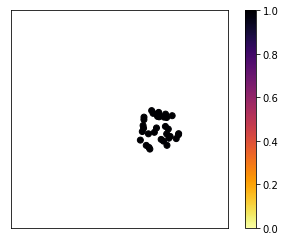

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:pred


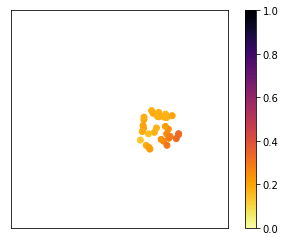

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:pred


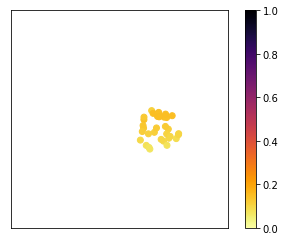

Vizualizing test_task:BASE:ind attention on labelset:slice_1:ind


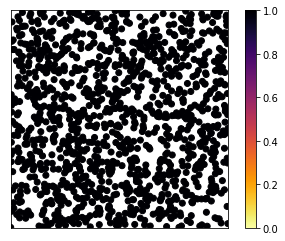

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:ind


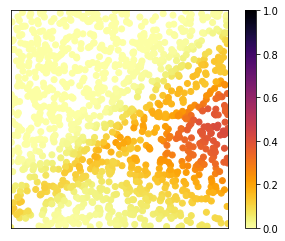

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:ind


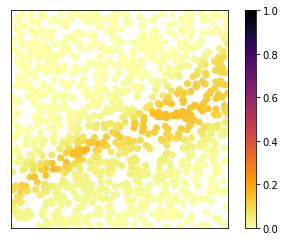

Vizualizing test_task:BASE:ind attention on labelset:slice_2:pred


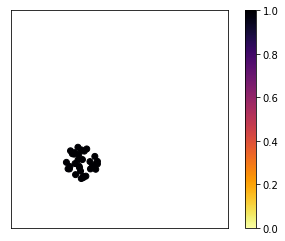

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:pred


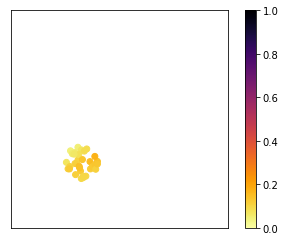

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:pred


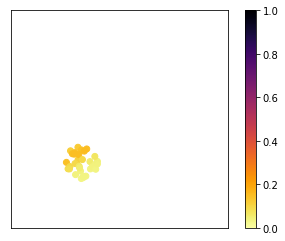

Vizualizing test_task:BASE:ind attention on labelset:slice_2:ind


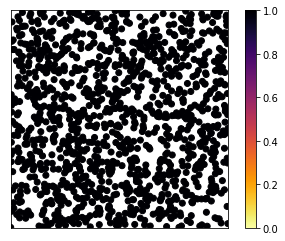

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:ind


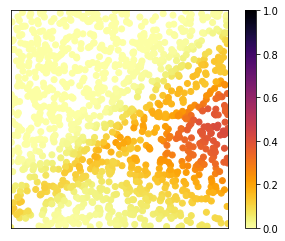

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:ind


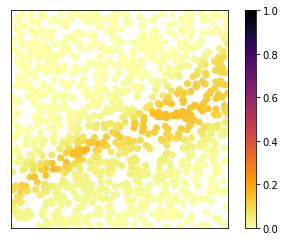

Vizualizing test_task:BASE:ind attention on labelset:remainder:pred


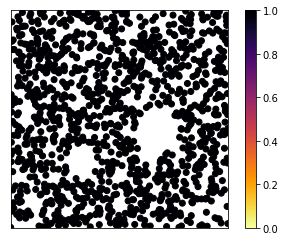

Vizualizing test_task:slice_1:ind attention on labelset:remainder:pred


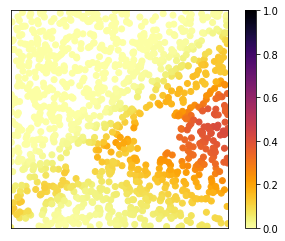

Vizualizing test_task:slice_2:ind attention on labelset:remainder:pred


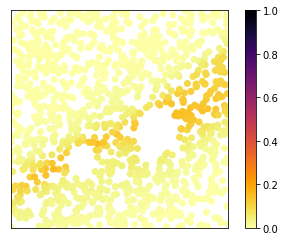

In [15]:
for model_name in trained_models.keys():
    if model_name not in ['soft_param', 'soft_param_rep', 'slice_qp_rep']:
        continue

    print(f'{"*"*10} {model_name} {"*"*10}')
    eval_payload.remap_labelsets(labels_to_tasks = {
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind"
        }
    )

    visualize_attention(trained_models[model_name], eval_payload)

## 